# Ray tracing in Mojo

This tutorial about [ray tracing](https://en.wikipedia.org/wiki/Ray_tracing_(graphics)) is based on the popular tutorial [Understandable RayTracing in C++](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing). The mathematical explanations are well described in that tutorial, so we'll just point you to the appropriate sections for reference as we implement a basic ray tracer in Mojo.

## Step 1: Basic definitions

We'll start by defining a `Vec3f` struct, which will use to represent a vector in 3D space as well as RGB pixels. We'll use a `SIMD` representation for our vector to enable vectorized operations. Note that since the SIMD type only allows a power of 2, we always pad the underlying storage with a 0.

In [1]:
from Math import _bits_to_float, _float_to_bits
from DType import DType

@register_passable("trivial")
struct Vec3f:
  var data: SIMD[DType.float32, 4]

  @always_inline
  fn __init__(x: Float32, y: Float32, z: Float32) -> Self:
    return Vec3f{data: SIMD[DType.float32, 4](x,y,z,0)}

  @always_inline
  fn __init__(data: SIMD[DType.float32, 4]) -> Self:
    return Vec3f{data: data}

  @always_inline
  @staticmethod
  fn zero() -> Vec3f:
    return Vec3f(0, 0, 0)

  @always_inline
  fn __sub__(self, other: Vec3f) -> Vec3f:
    return self.data - other.data

  @always_inline
  fn __add__(self, other: Vec3f) -> Vec3f:
    return self.data + other.data

  @always_inline
  fn __matmul__(self, other: Vec3f) -> Float32:
    return (self.data * other.data).reduce_add()

  @always_inline
  fn __mul__(self, k: Float32) -> Vec3f:
    return self.data * k

  @always_inline
  fn cross(self, other: Vec3f) -> Vec3f:
    let self_zxy = self.data.shuffle[2, 0, 1, 3]()
    let other_zxy = other.data.shuffle[2, 0, 1, 3]()
    return (self_zxy * other.data - self.data * other_zxy).shuffle[2, 0, 1, 3]()

  @always_inline
  fn normalize(self) -> Vec3f:
    return self.data * fast_rsqrt(self @ self)

fn fast_rsqrt[type:DType, simd_width:Int](x: SIMD[type, simd_width]) -> SIMD[type, simd_width]:
    """Fast inverse sqrt as defined in 
    https://en.wikipedia.org/wiki/Fast_inverse_square_root
    """
    alias integral_type = DType.int32
    let i = 0x5f3759df - (_float_to_bits[simd_width, type, integral_type](x) >> 1)
    let f = _bits_to_float[simd_width, integral_type, type](i)
    return f * (1.5 - (0.5* x * f * f))

We now define our `Image` struct, which will store the RGB pixels of our images. It also contains a method to conver this Mojo struct into a numpy image, which will be used for implementing a straightforward displaying mechanism.

In [2]:
struct Image:
  var rc: Pointer[Int] # reference count used to make the object efficiently copyable
  var pixels: Pointer[Vec3f] # the two dimensional image is represented as a flat array
  var height: Int
  var width: Int
  
  fn __init__(inout self, height: Int, width: Int):
    self.height = height
    self.width = width
    self.pixels = Pointer[Vec3f].alloc(self.height * self.width)
    self.rc = Pointer[Int].alloc(1)
    self.rc.store(1)
  
  fn __copyinit__(inout self, other: Self):
    other._inc_rc()
    self.pixels = other.pixels
    self.rc   = other.rc
    self.height = other.height
    self.width = other.width
    
  fn __del__(owned self):
    self._dec_rc()

  fn _get_rc(self) -> Int:
    return self.rc.load()

  fn _dec_rc(self):
    let rc = self._get_rc()
    if rc > 1:
      self.rc.store(rc - 1)
      return
    self._free()

  fn _inc_rc(self):
    let rc = self._get_rc()
    self.rc.store(rc + 1)

  fn _free(self):
    self.rc.free()
    self.pixels.free()
  
  @always_inline
  fn set(self, row: Int, col: Int, value: Vec3f) -> None:
    self.pixels.store(self._pos_to_index(row, col), value)

  @always_inline
  fn _pos_to_index(self, row: Int, col: Int) -> Int:
    # Convert a (rol, col) position into an index in the underlying linear storage
    return row * self.width + col
    
  def to_numpy_image(self) -> PythonObject:
    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")

    let np_image = np.zeros((self.height, self.width, 3), np.float32)

    # We use raw pointers to efficiently copy the pixels to the numpy array

    let out_pointer = Pointer(__mlir_op.`pop.index_to_pointer`[_type:__mlir_type.`!pop.pointer<scalar<f32>>>`](
        SIMD[DType.index,1](np_image.__array_interface__['data'][0].__index__()).value
    ))
    let in_pointer = Pointer(__mlir_op.`pop.index_to_pointer`[_type:__mlir_type.`!pop.pointer<scalar<f32>>>`](
        SIMD[DType.index,1](self.pixels.__as_index()).value
    ))

    for row in range(self.height):
      for col in range(self.width):
        let index = self._pos_to_index(row, col)
        for dim in range(3):
            out_pointer.store(index * 3 + dim, in_pointer[index * 4 + dim])
        
    return np_image

We then add a function for quickly displaying an `Image` into the notebook. Our Python interopt comes in quite handy.

In [3]:
def render(image: Image):
  np = Python.import_module("numpy")
  plt = Python.import_module("matplotlib.pyplot")
  colors = Python.import_module("matplotlib.colors")
  dpi = 32
  fig = plt.figure(1, [image.height // 10, image.width // 10], dpi)

  plt.imshow(image.to_numpy_image())
  plt.axis("off")
  plt.show()

Finally, we test all our code so far with a simple image, which is the one rendered in the [Step 1 of the C++ tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-1-write-an-image-to-the-disk).

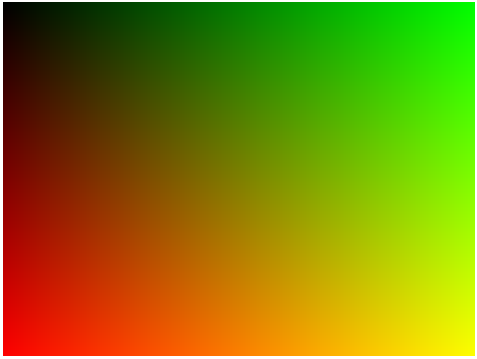

In [4]:
let image = Image(192, 256)

for row in range(image.height):
  for col in range(image.width):
    image.set(
      row, col, 
      Vec3f(Float32(row) / image.height, Float32(col) / image.width, 0)
    )
    
render(image)

## Step 2: Ray tracing

Now we'll perform ray tracing from a camera into a scene with a sphere. Before reading the code below, we suggest you read more about how this works conceptually from [Step 2 of the C++ tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-2-the-crucial-one-ray-tracing).

We first define the `Material` and `Sphere` structs, which are the new data structures we'll need.

In [5]:
from Math import sqrt

@register_passable("trivial")
struct Material:
  var color: Vec3f
  
  fn __init__(color: Vec3f) -> Material:
    return Material{color: color}
    

let ivory = Material(Vec3f(0.4, 0.4, 0.3))
let red_rubber = Material(Vec3f(0.3, 0.1, 0.1))


@register_passable("trivial")
struct Sphere:
  var center: Vec3f
  var radius: Float32
  var material: Material
  
  fn __init__(c: Vec3f, r: Float32, material: Material) -> Self:
    return Sphere {center: c, radius: r, material: material}
    
  @always_inline
  fn intersects(self, orig: Vec3f, dir: Vec3f, inout dist: Float32) -> Bool:
    ''' This method returns True if a given ray intersects this sphere. 
        And if it does, it writes in the `dist` parameter the distance to the 
        origin of the ray.
    '''
    let L = orig - self.center 
    let a = dir @ dir 
    let b = 2 * (dir @ L)
    let c = L @ L - self.radius * self.radius
    let discriminant = b * b - 4 * a * c
    if discriminant < 0:
      return False
    if discriminant == 0:
      dist = -b / 2*a
      return True
    let q = -0.5 * (b + sqrt(discriminant))
            if b > 0 else -0.5 * (b - sqrt(discriminant))
    var t0 = q / a
    let t1 = c / q 
    if t0 > t1:
      t0 = t1 
    if t0 < 0:
      t0 = t1 
      if t0 < 0:
        return False 
    
    dist = t0
    return True


    

We then define a `cast_ray` method, which will be used to figure out the color of a particular pixel in the image we'll produce. It basically works by identifying whether this ray intersects the sphere or not.

In [6]:
fn cast_ray(orig: Vec3f, dir: Vec3f, sphere: Sphere) -> Vec3f:
    var dist: Float32 = 0
    if not sphere.intersects(orig, dir, dist):
        return Vec3f(0.2, 0.7, 0.8); # background color
    
    return sphere.material.color

Lastly, we parallelize the ray tracing for every pixel row-wise.

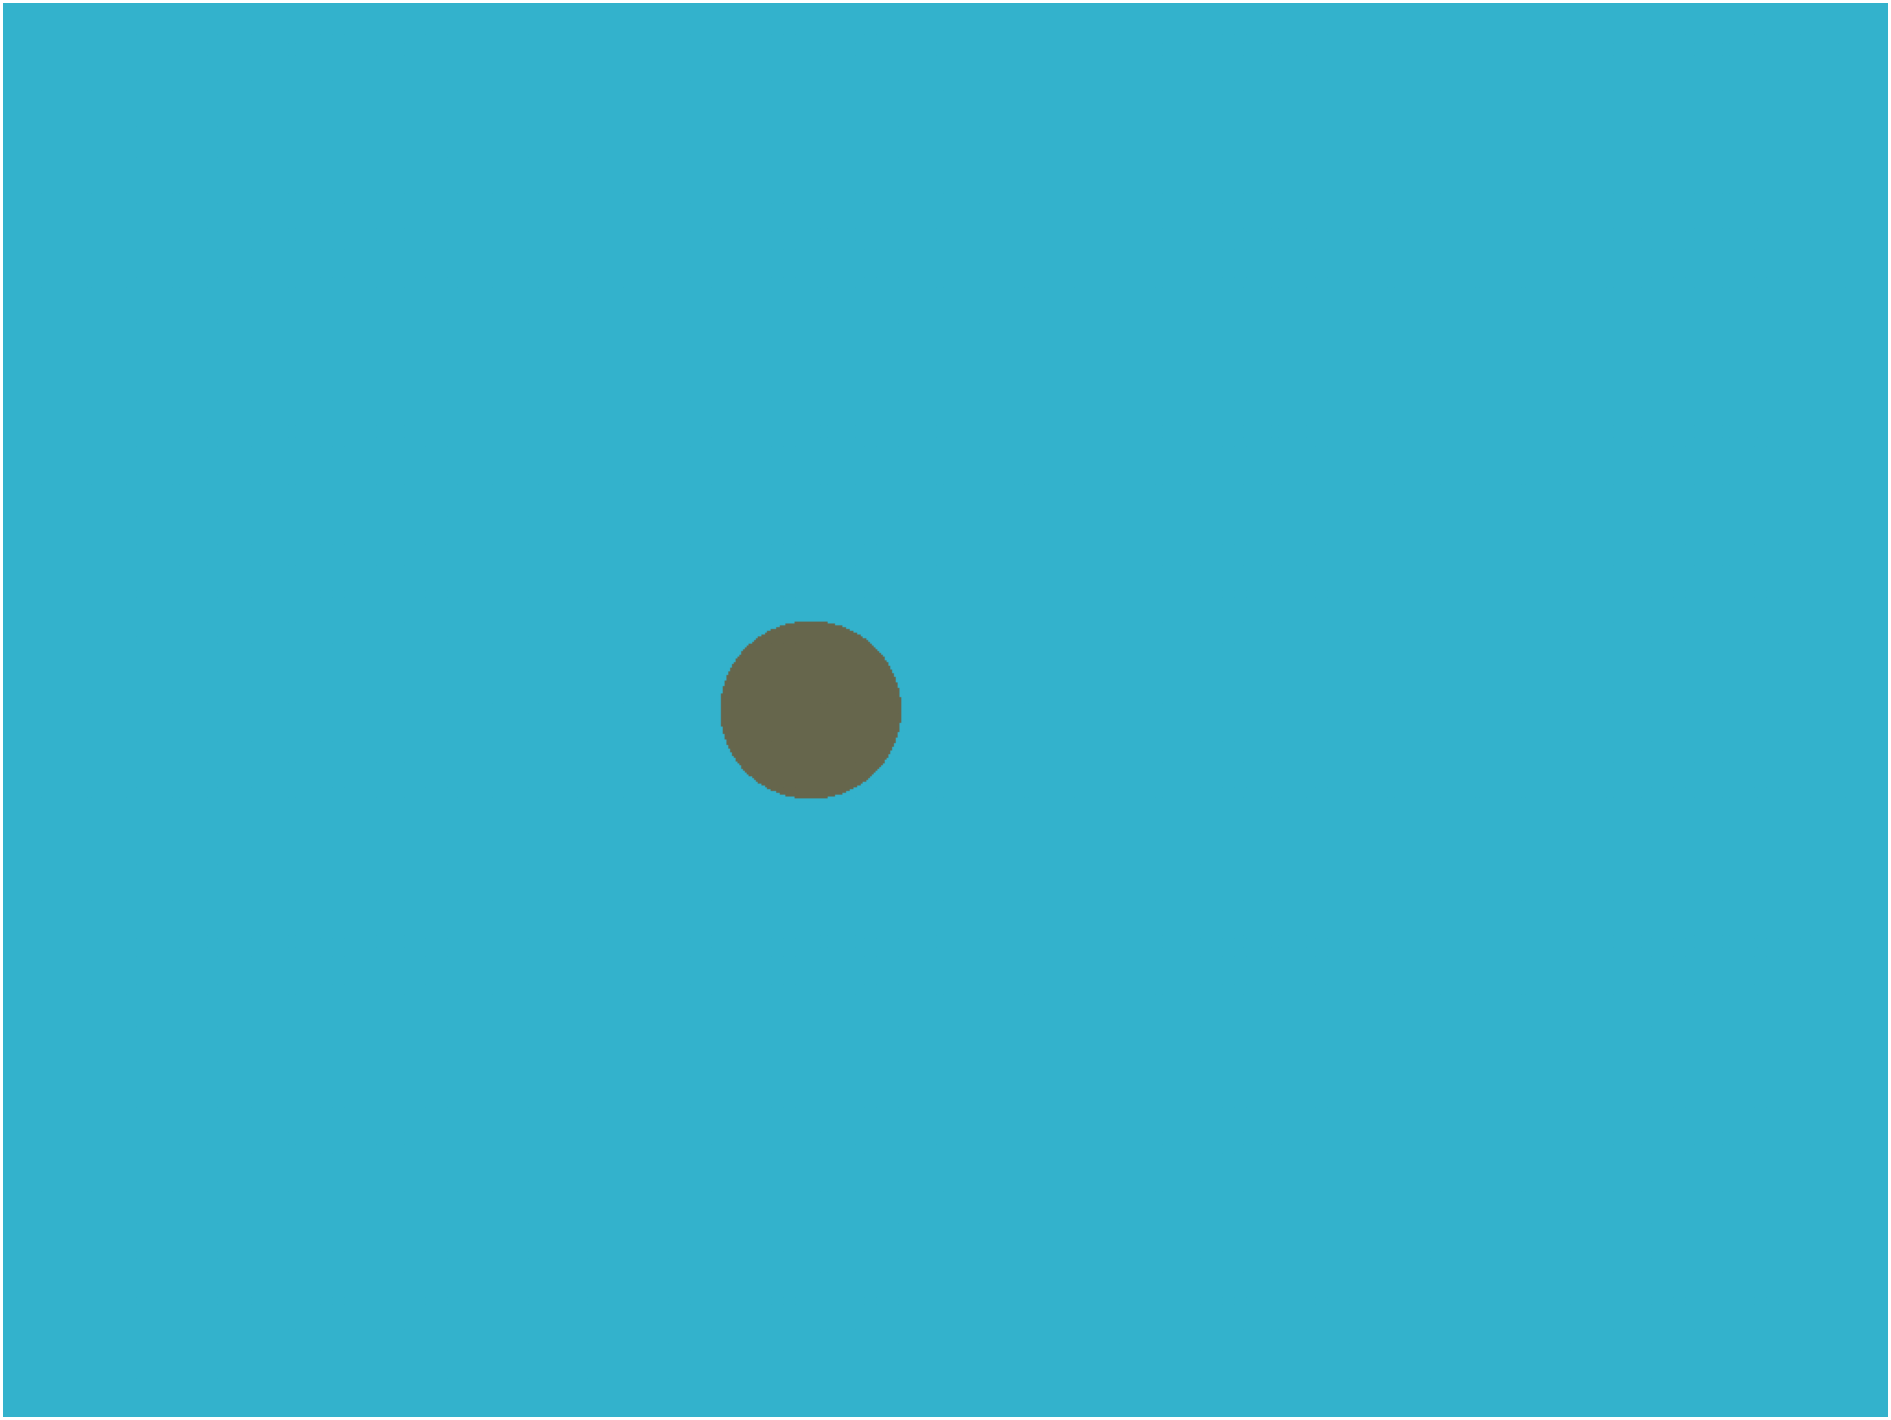

In [7]:
from Math import tan, acos
from Functional import parallelize

fn create_image_with_sphere(sphere: Sphere, height: Int, width: Int) -> Image:
  let image = Image(height, width)

  @parameter
  fn _process_row(row: Int):
    let y = -((2.0*row + 1) / height - 1)
    for col in range(width):
      let x = ((2.0*col + 1) / width - 1) * width / height
      let dir = Vec3f(x, y, -1).normalize();
      image.set(row, col, cast_ray(Vec3f.zero(), dir, sphere))
 
  parallelize[_process_row](height)
  
  return image
  
render(create_image_with_sphere(Sphere(Vec3f(-3, 0, -16), 2, ivory), 768, 1024))

## Step 3: More spheres

This section corresponds to the [Step 3 of the C++ tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-3-add-more-spheres). 

We include here all the necessary changes:

- We add 3 more spheres to the scene, 2 of them being of ivory material.
- When we intersect the ray with the sphere, we render the color of the closest sphere.

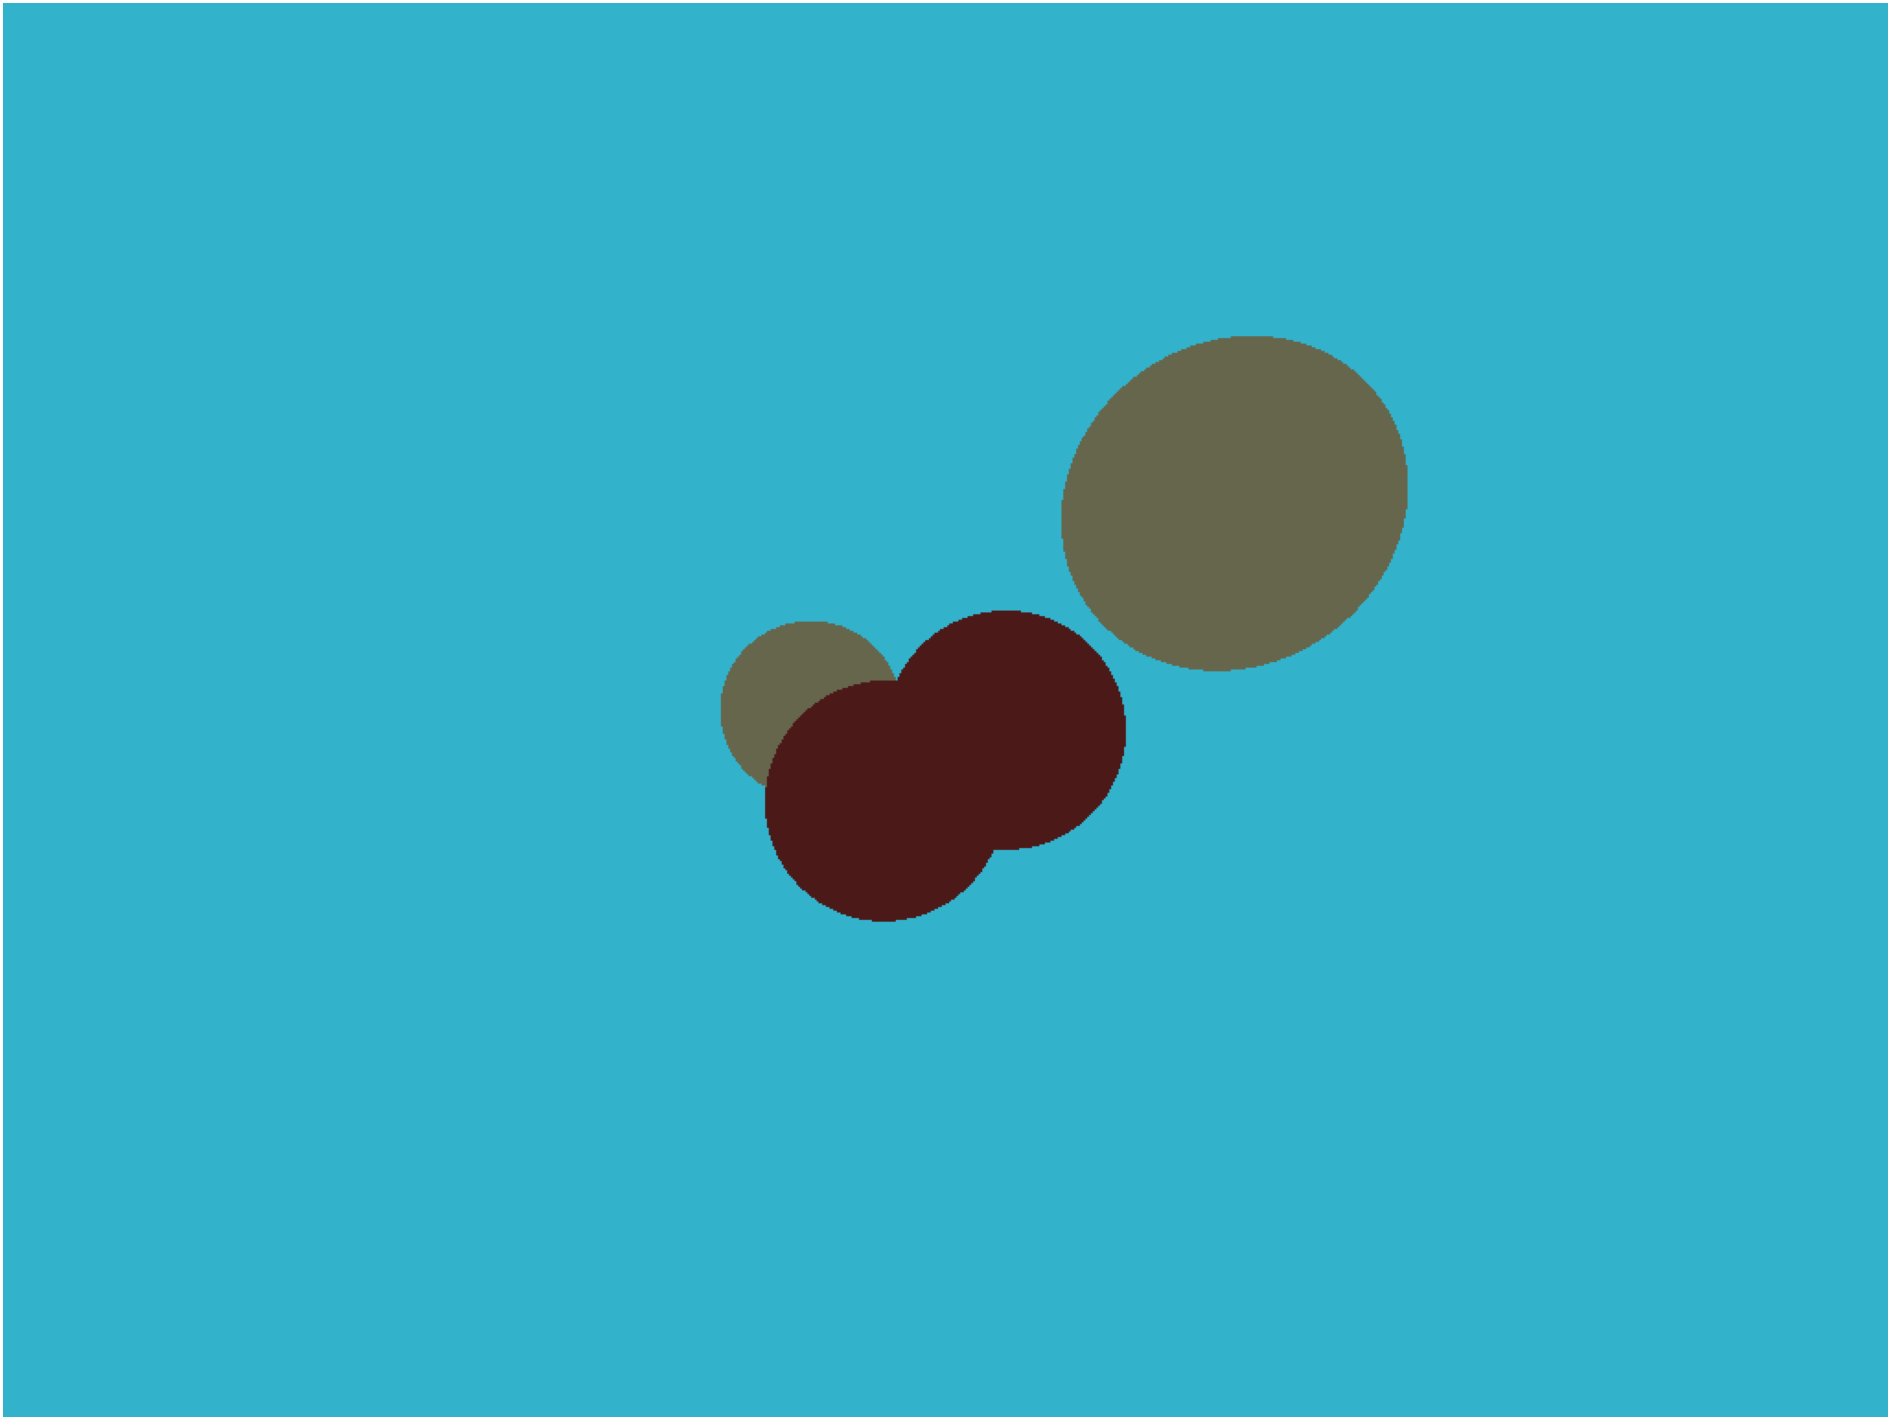

In [8]:
from Functional import parallelize
from Vector import DynamicVector
from Math import inf

fn scene_intersect(
    orig: Vec3f, dir: Vec3f, spheres: DynamicVector[Sphere], background: Material
) -> Material:
  var spheres_dist = inf[DType.float32]()
  var material = background
  
  for i in range(0, spheres.size):
    var dist = inf[DType.float32]()
    if spheres[i].intersects(orig, dir, dist) and dist < spheres_dist:
      spheres_dist = dist;
      material = spheres[i].material;
      
  return material

fn cast_ray(orig: Vec3f, dir: Vec3f, spheres: DynamicVector[Sphere]) -> Material:
    let background = Material(Vec3f(0.2, 0.7, 0.8)) 
    return scene_intersect(orig, dir, spheres, background)

fn create_image_with_spheres(spheres: DynamicVector[Sphere], height: Int, width: Int) -> Image:
  let image = Image(height, width)

  @parameter
  fn _process_row(row: Int):
    let y = -((2.0*row + 1) / height - 1)
    for col in range(width):
      let x = ((2.0*col + 1) / width - 1) * width / height
      let dir = Vec3f(x, y, -1).normalize();
      image.set(row, col, cast_ray(Vec3f.zero(), dir, spheres).color)
 
  parallelize[_process_row](height)
  
  return image
  
let spheres = DynamicVector[Sphere]()
spheres.push_back(Sphere(Vec3f(-3, 0, -16), 2, ivory));
spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2, red_rubber));
spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,      ivory));

render(create_image_with_spheres(spheres, 768, 1024))

## Step 4: Add lighting

This section corresponds to the [Step 4 of the C++ tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing#step-4-lighting). Please read that section for an explanation of the trick used to estimate the light intensity of pixel based on the angle of intersection between each ray and the spheres. The changes are minimal and are primarily about handling this intersection angle.

In [9]:
@register_passable("trivial")
struct Light:
  var position: Vec3f
  var intensity: Float32
  
  fn __init__(p: Vec3f, i: Float32) -> Self:
    return Light {position: p, intensity: i}

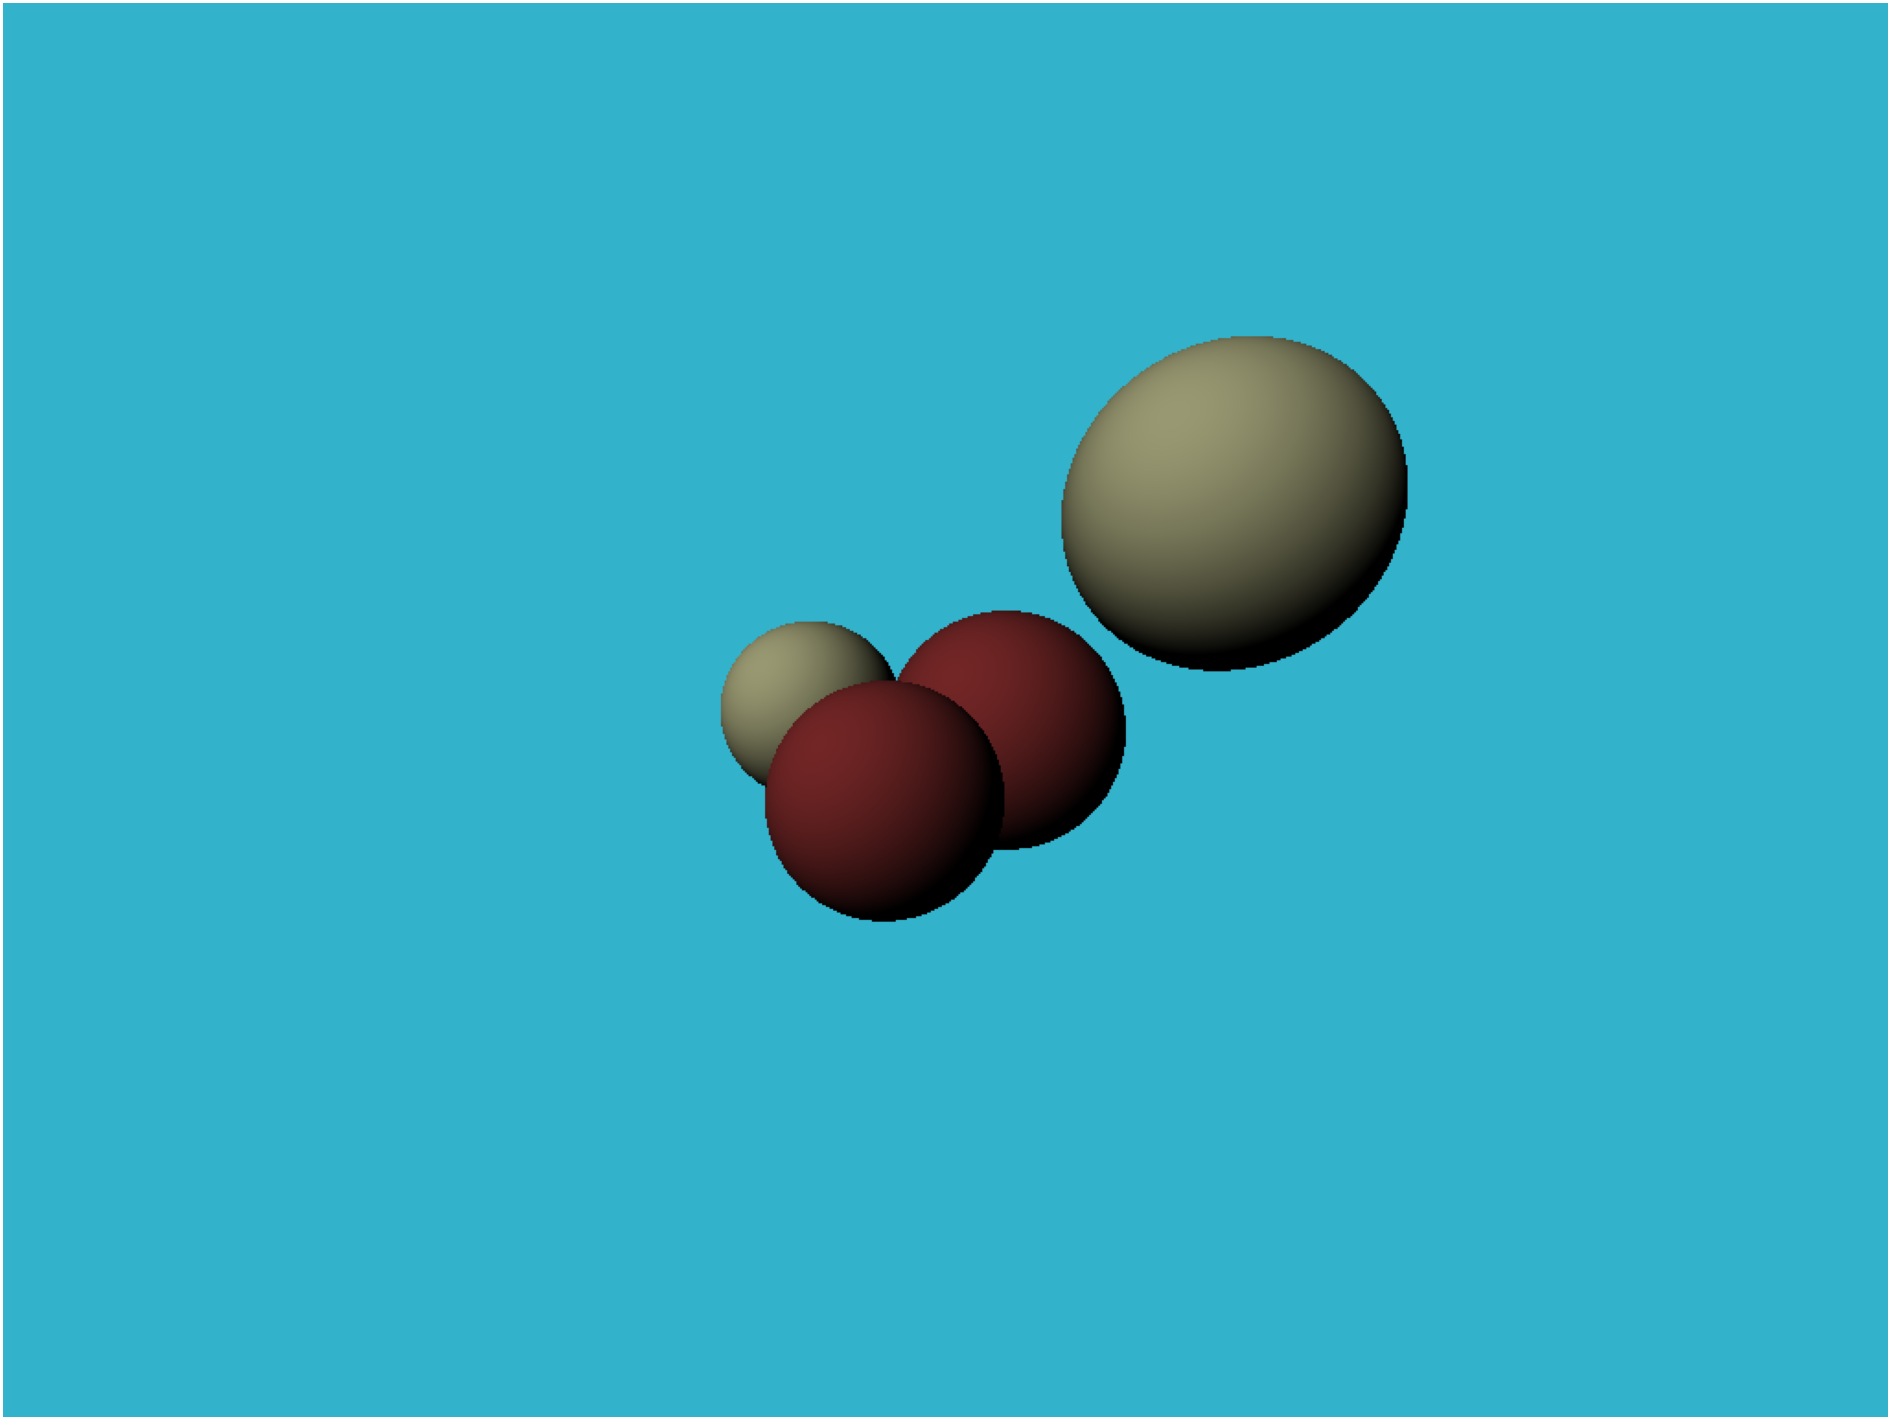

In [10]:
from Math import max 

fn scene_intersect(
    orig: Vec3f, dir: Vec3f, spheres: DynamicVector[Sphere], inout material: Material,
    inout hit: Vec3f, inout N: Vec3f,
) -> Bool:
  var spheres_dist = inf[DType.float32]()
  
  for i in range(0, spheres.size):
    var dist: Float32 = 0
    if spheres[i].intersects(orig, dir, dist) and dist < spheres_dist:
      spheres_dist = dist;
      hit = orig + dir * dist
      N = (hit - spheres[i].center).normalize();
      material = spheres[i].material;
      
  return (spheres_dist != inf[DType.float32]()).__bool__()
  
fn cast_ray(orig: Vec3f, dir: Vec3f, spheres: DynamicVector[Sphere], lights: DynamicVector[Light]) -> Material:
    var point = Vec3f.zero()
    var material = Material(Vec3f.zero())
    var N = Vec3f.zero()
    if not scene_intersect(orig, dir, spheres, material, point, N):
      return Material(Vec3f(0.2, 0.7, 0.8)) # background
      
    var diffuse_light_intensity: Float32 = 0;
    for i in range(lights.size):
        let light_dir = (lights[i].position - point).normalize()
        diffuse_light_intensity += lights[i].intensity * max(0, light_dir @ N);
    
    return material.color * diffuse_light_intensity

fn create_image_with_spheres_and_lights(
    spheres: DynamicVector[Sphere], lights: DynamicVector[Light], height: Int, width: Int
) -> Image:
  let image = Image(height, width)

  @parameter
  fn _process_row(row: Int):
    let y = -((2.0*row + 1) / height - 1)
    for col in range(width):
      let x = ((2.0*col + 1) / width - 1) * width / height
      let dir = Vec3f(x, y, -1).normalize();
      image.set(
        row, col,
        cast_ray(Vec3f.zero(), dir, spheres, lights).color
      )
 
  parallelize[_process_row](height)
  
  return image
  
let spheres = DynamicVector[Sphere]()
spheres.push_back(Sphere(Vec3f(-3, 0, -16), 2, ivory));
spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2, red_rubber));
spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,      ivory));

let lights = DynamicVector[Light]()
lights.push_back(Light(Vec3f(-20, 20,  20), 1.5));

render(create_image_with_spheres_and_lights(spheres, lights, 768, 1024))

## Next steps

We've only explored the basics of ray tracing here, but you can add much more, such as specular lighting, shadows, and reflections. Fortunately these are explained in [the C++ tutorial](https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing), and we leave the corresponding Mojo implementations as an exercise for you.